In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Test data

In [3]:
from utils.data.grasp_anything_data import GraspAnythingDataset
from inference.post_process import post_process_output
from utils.data import get_dataset
from utils.dataset_processing import evaluation, grasp
from utils.visualisation.plot import save_results
from train_network_PromptGD import custom_collate_fn
from utils.visualisation.plot import save_results, plot_grasp, plot_results

In [24]:
dataset = GraspAnythingDataset('/home/bdi/AdvancedLiterateMachinery/DocumentUnderstanding/CLIP_OCR/Dataset/grasp-anything++/seen', seen=True,)

# Creating data indices for training and validation splits
indices = list(range(dataset.length))
split = int(np.floor(0.9 * dataset.length))

np.random.seed(42)
np.random.shuffle(indices)
train_indices, val_indices = indices[:split], indices[split:]

train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_indices)

train_data = torch.utils.data.DataLoader(
    dataset,
    batch_size=1,
    num_workers=8,
    sampler=train_sampler,
    collate_fn=custom_collate_fn
)
val_data = torch.utils.data.DataLoader(
    dataset,
    batch_size=1,
    num_workers=8,
    sampler=val_sampler,
    collate_fn=custom_collate_fn
)

In [26]:
device = torch.device('cuda')

In [27]:
path_weight = "/home/bdi/AdvancedLiterateMachinery/DocumentUnderstanding/CLIP_OCR/Grasp-Anything/logs/ld_grasp/240429_1300_/epoch_48_iou_0.36"
net = torch.load(path_weight).to(device)

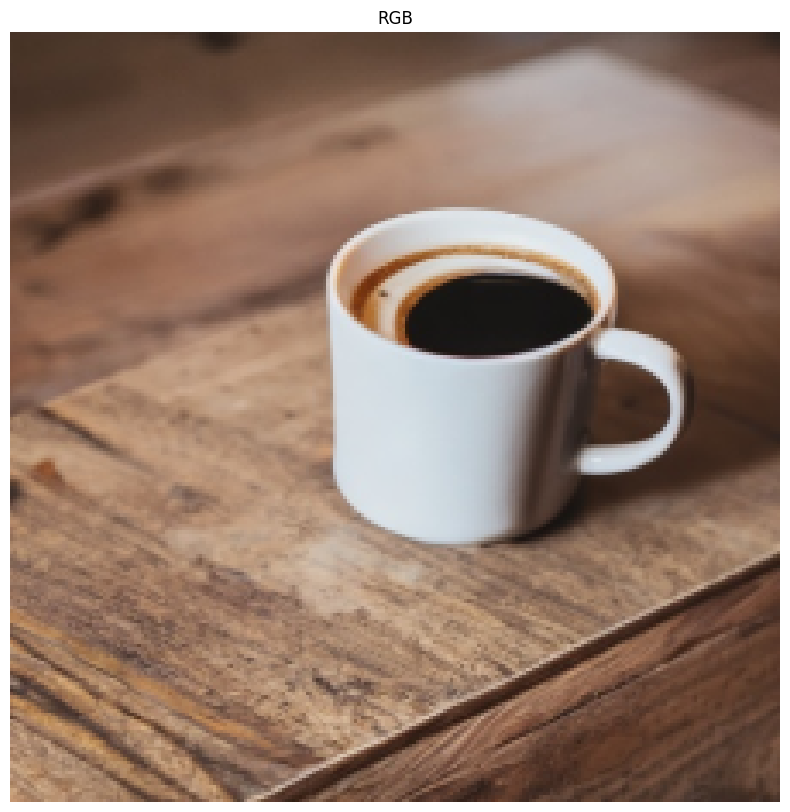

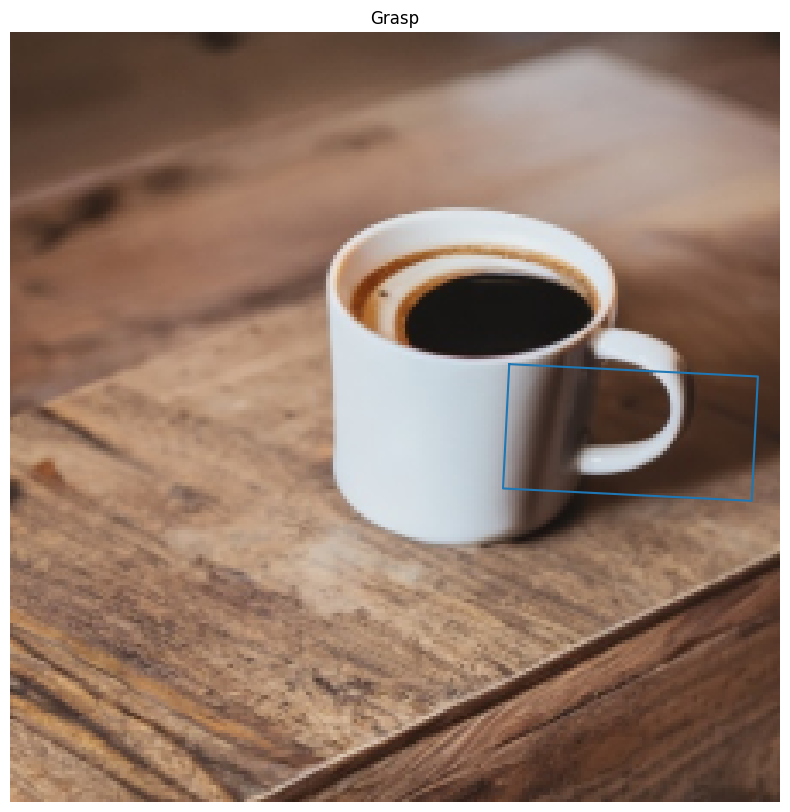

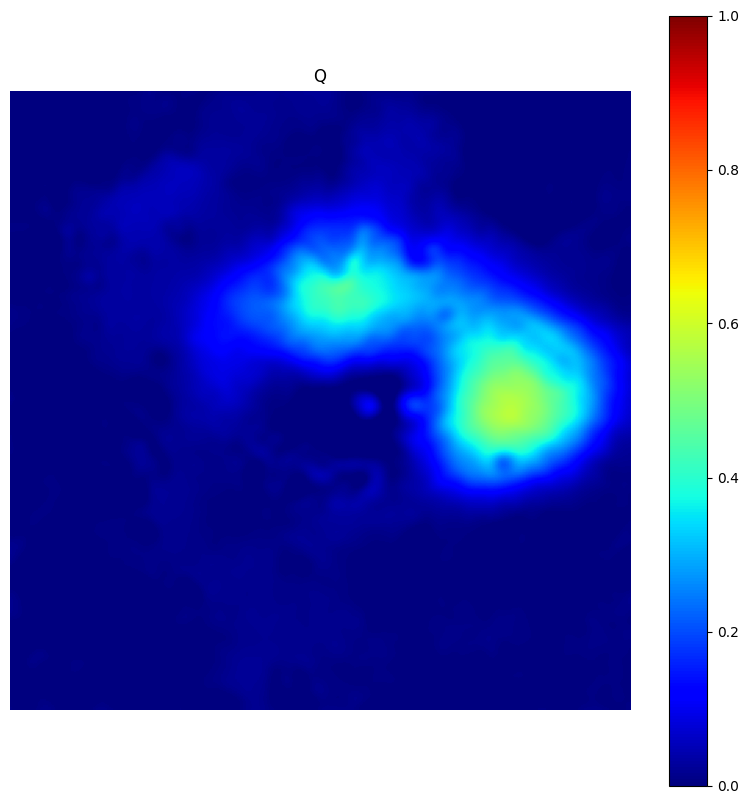

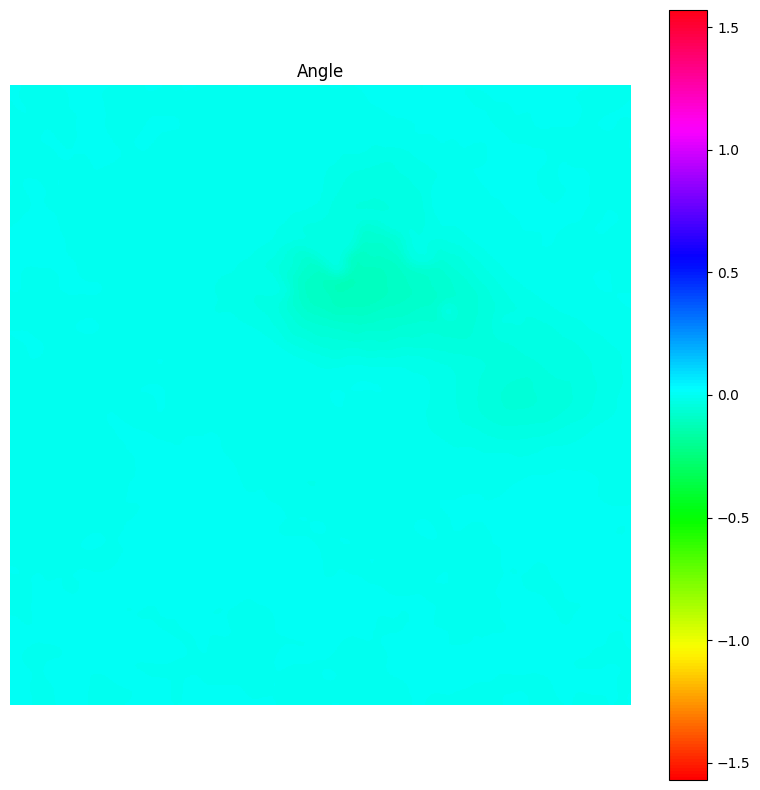

In [85]:
x, y, didx, rot, zoom, text = next(iter(train_data))
with torch.no_grad():
    xc = x.to(device)
    yc = [yi.to(device) for yi in y]
    text = text.to(device)
    net.eval()
    lossd = net.compute_loss(xc, yc, text)

    q_img, ang_img, width_img = post_process_output(lossd['pred']['pos'], lossd['pred']['cos'],
                                                    lossd['pred']['sin'], lossd['pred']['width'])
    
    grasps = grasp.detect_grasps(q_img, ang_img, width_img=width_img, no_grasps=1)
    save_results(path_save="/home/bdi/AdvancedLiterateMachinery/DocumentUnderstanding/CLIP_OCR/Grasp-Anything/results_evaluate",
                rgb_img=train_data.dataset.get_rgb(didx[0], rot[0], zoom[0], normalise=False),
                grasp_q_img=q_img,
                grasp_angle_img=ang_img,
                no_grasps=1,
                grasp_width_img=width_img
                )